# Viewing images of Varchamp wells
**Author:** Jessica Ewald <br>

The purpose of this script is to query image names by batch, plate, well, site, & channel, download from AWS, and render in a notebook. This will be useful for quick visual sanity checks.

In [3]:
# Imports
import polars as pl
import numpy as np
from sh import aws
import os
from skimage.io import imread
from matplotlib import pyplot as plt

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

In [4]:
# get sample metadata
dat = pl.scan_parquet("/dgx1nas1/storage/data/jess/varchamp/sc_data/processed_profiles/Rep_Ctrls/annotated_normalized_featselected.parquet")

meta_cols = [i for i in dat.columns if "Metadata_" in i]

dat = dat.select(meta_cols).collect()

In [19]:
dat.filter(pl.col("Metadata_allele").is_in(["ALK_", "ALK_R1275Q"])).select(["Metadata_Well", "Metadata_allele"]).unique().head

<bound method DataFrame.head of shape: (96, 2)
┌───────────────┬─────────────────┐
│ Metadata_Well ┆ Metadata_allele │
│ ---           ┆ ---             │
│ str           ┆ str             │
╞═══════════════╪═════════════════╡
│ E06           ┆ ALK_            │
│ E05           ┆ ALK_            │
│ H15           ┆ ALK_R1275Q      │
│ D21           ┆ ALK_R1275Q      │
│ N06           ┆ ALK_            │
│ …             ┆ …               │
│ O24           ┆ ALK_R1275Q      │
│ E02           ┆ ALK_            │
│ B20           ┆ ALK_            │
│ N13           ┆ ALK_R1275Q      │
│ F19           ┆ ALK_R1275Q      │
└───────────────┴─────────────────┘>

In [36]:
# Define mapping between simple names and folder names
batch_dict = {"B4A3R1": "2023-12-15_B4A3R1",
              "B6A3R2": "2023-12-21_B6A3R2"}

letter_dict = {"A":"01", "B":"02", "C":"03", "D":"04", "E":"05", "F":"06", "G":"07", "H":"08", "I":"09", "J":"10", "K":"11", "L":"12", "M":"13", "N":"14", "O":"15", "P":"16"}

plate_dict = {"B4-T1": "2023-12-15_B4A3R1_P1T1__2023-12-15T08_49_02-Measurement1",
              "B4-T2": "2023-12-15_B4A3R1_P1T2__2023-12-15T10_35_54-Measurement1",
              "B4-T3": "2023-12-18_B4A3R1_P1T3__2023-12-18T08_29_45-Measurement1",
              "B4-T4": "2023-12-18_B4A3R1_P1T4__2023-12-18T10_17_07-Measurement1",
              "B6-T1": "2023-12-21_B6A3R2_P1T1__2023-12-21T08_28_37-Measurement1",
              "B6-T2": "2023-12-21_B6A3R2_P1T2__2023-12-21T10_11_34-Measurement1",
              "B6-T3": "2023-12-21_B6A3R2_P1T3__2023-12-21T11_57_14-Measurement1",
              "B6-T4": "2023-12-21_B6A3R2_P1T4__2023-12-21T13_40_04-Measurement1"}

channel_dict_T1T2 = {"DAPI":"2", "GFP":"1", "Mito":"3", "AGP":"4", "Brightfield1":"5", "Brightfield2":"6", "Brightfield":"7"}
channel_dict_T3T4 = {"DAPI":"1", "GFP":"2", "Mito":"3", "AGP":"4", "Brightfield1":"5", "Brightfield2":"6", "Brightfield":"7"}

file exists!


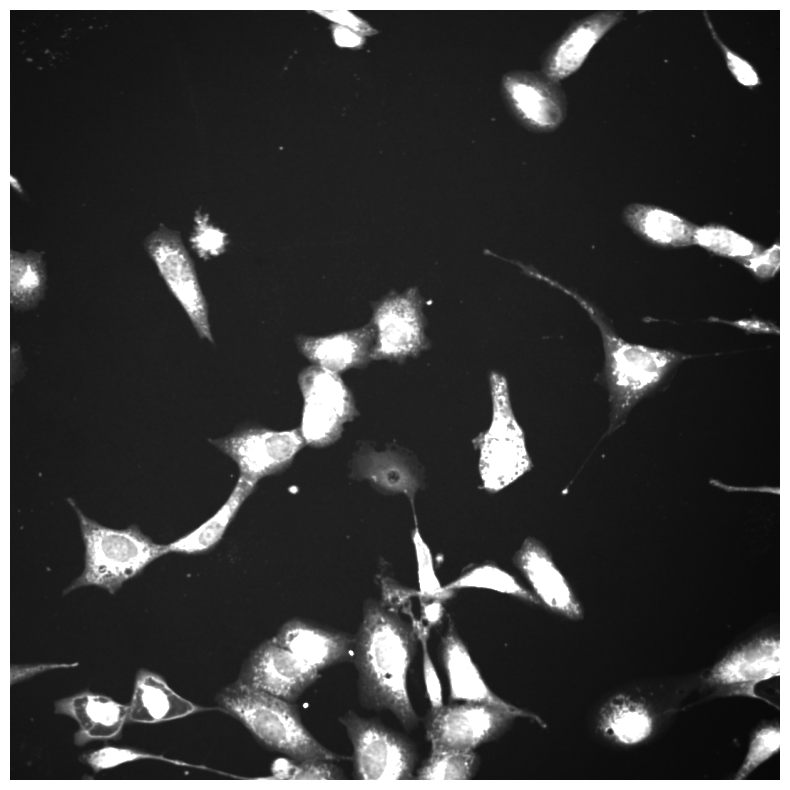

file exists!


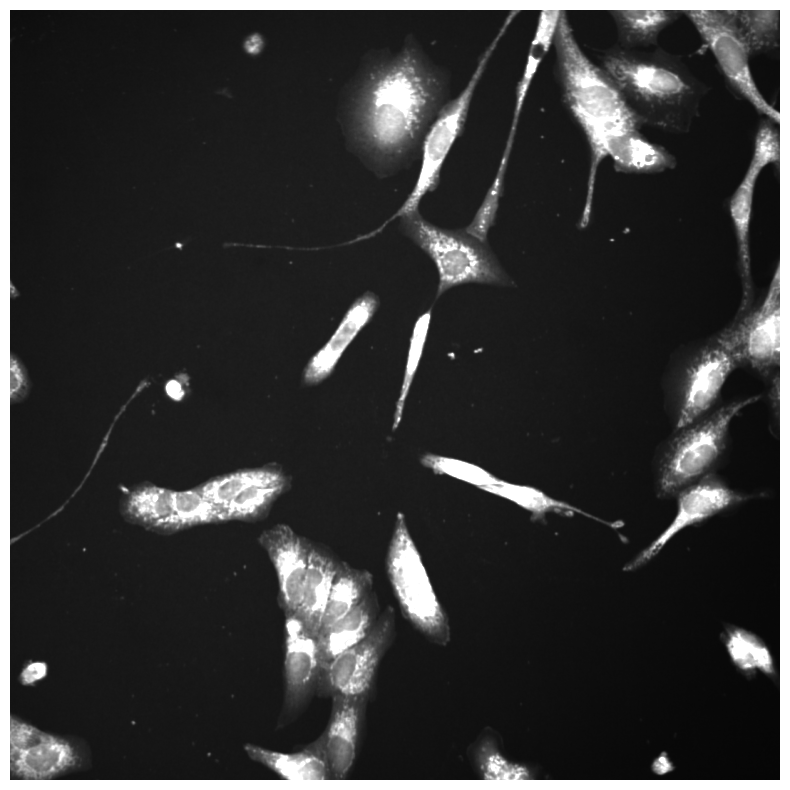

In [42]:
# Specify image parameters
sel_batch = "B6A3R2"
sel_plate = "B6-T1"
site = "05"
well = "H15"
sel_channel = "AGP"

plotImages(sel_batch, "B6-T1", site, "E06", sel_channel, 10000)
plotImages(sel_batch, "B6-T3", site, "E06", sel_channel, 10000)

In [27]:
def plotImages(sel_batch, sel_plate, site, well, sel_channel, max_val):
    # construct image name and aws path
    letter = well[0]
    col = well[1:3]
    batch = batch_dict[sel_batch]
    row = letter_dict[letter]
    plate = plate_dict[sel_plate]

    #if sel_plate in ["T1", "T2"]:
    channel = channel_dict_T1T2[sel_channel]
    #else:
        #channel = channel_dict_T1T2[sel_channel]

    img_nm = f"r{row}c{col}f{site}p01-ch{channel}sk1fk1fl1.tiff"

    aws_path = f"s3://cellpainting-gallery/cpg0020-varchamp/broad/images/{batch}/images/{plate}/Images/{img_nm}"
    dgx_path = f"/dgx1nas1/storage/data/jess/varchamp/images/{sel_batch}/{sel_plate}"
    
    # construct folder path in DGX
    os.makedirs(dgx_path, exist_ok=True) 

    # download image if it doesn't already exist
    if os.path.isfile(f"{dgx_path}/{img_nm}"):
        print("file exists!")
    else:
        aws("s3",
            "cp",
            aws_path, 
            f"{dgx_path}/{img_nm}")
        print("downloaded file!")
        
    # read tiff into numpy array
    img = imread(f"{dgx_path}/{img_nm}", as_gray=True)
    img.max()
    
    # display plot
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap="gray", vmin=0, vmax=max_val)
    plt.axis('off')
    plt.show()